<a href="https://colab.research.google.com/github/Sadegh-rad/NAS_for_TVWW/blob/main/4A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### TODO:


1.   complete requirements.txt
2.   add plots code
3.   showing the results of fly image(optional)





# Importing needed libraries

In [ ]:
!pip install torchinfo
!pip install pyvww
!pip install bayesian-optimization

In [ ]:
import torch
import torch.nn as nn
import torchvision
# from torchvision.models.detection import FasterRCNN
# from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from google.colab import drive
import shutil
import pyvww
import random
from sklearn.model_selection import train_test_split
from torchvision.transforms import RandomResizedCrop
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchinfo import summary
from bayes_opt import BayesianOptimization
import torch.optim.lr_scheduler
import seaborn as sns

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Load Data and make it ready for next parts

In [ ]:
# Getting access to the goolge drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import shutil
shutil.unpack_archive("/content/drive/MyDrive/polito/vww/COCO.zip", "/content/sample_data")

In [ ]:
# Custom Dataset class for the balanced dataset and process data to have our divided datasets
class BalancedVisualWakeWordsDataset(torch.utils.data.Dataset):
    def __init__(self, visual_wake_words_dataset):
        self.visual_wake_words_dataset = visual_wake_words_dataset

    def __getitem__(self, index):
        return self.visual_wake_words_dataset[index]

    def __len__(self):
        return len(self.visual_wake_words_dataset)

def create_balanced_dataset(dataset, target_class=1):
    positive_data = []
    negative_data = []

    for img, target in dataset:
        if target == target_class:
            positive_data.append((img, target))
        else:
            negative_data.append((img, target))

    num_samples = min(len(positive_data), len(negative_data))
    positive_data = random.sample(positive_data, num_samples)
    negative_data = random.sample(negative_data, num_samples)

    balanced_data = positive_data + negative_data
    random.shuffle(balanced_data)

    return balanced_data

augmented_data_transform = transforms.Compose([
    transforms.Resize(size=(96, 96)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    RandomResizedCrop(size=(96, 96), scale=(0.8, 1.0), ratio=(3/4, 4/3)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.ConvertImageDtype(torch.float16),
])

# Load the COCO dataset with the custom data transformations
# Load the COCO dataset
train_data = pyvww.pytorch.VisualWakeWordsClassification(
    root="/content/sample_data/all2014",
    annFile="/content/drive/MyDrive/polito/vww/annotations/instances_train.json",
    transform= augmented_data_transform)
val_data = pyvww.pytorch.VisualWakeWordsClassification(
    root="/content/sample_data/val2014",
    annFile="/content/drive/MyDrive/polito/vww/annotations/instances_val.json",
    transform= augmented_data_transform)

combined_data = train_data + val_data

balanced_combined_data = create_balanced_dataset(combined_data)

train_data_filtered, temp_data_filtered = train_test_split(balanced_combined_data, test_size=0.3, random_state=42)
val_data_filtered, test_data_filtered = train_test_split(temp_data_filtered, test_size=0.5, random_state=42)

train_dataset = BalancedVisualWakeWordsDataset(train_data_filtered)
val_dataset = BalancedVisualWakeWordsDataset(val_data_filtered)
test_dataset = BalancedVisualWakeWordsDataset(test_data_filtered)

loading annotations into memory...
Done (t=5.76s)
creating index...
index created!
loading annotations into memory...
Done (t=0.54s)
creating index...
index created!


## Visualizing ten random images with their labels

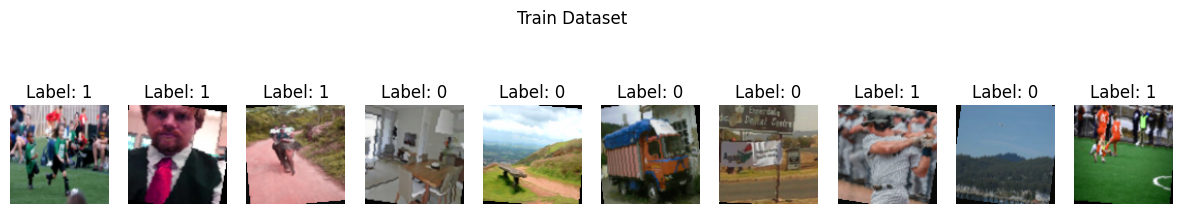

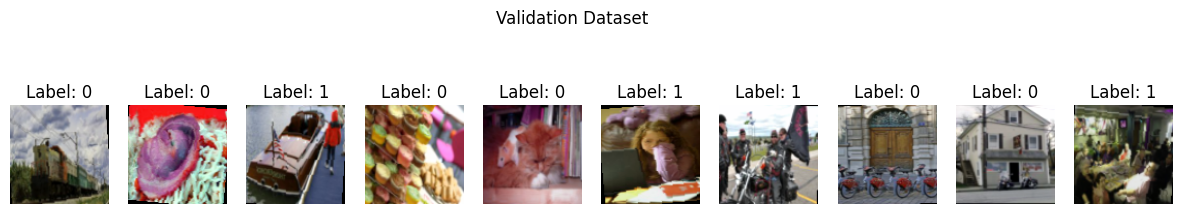

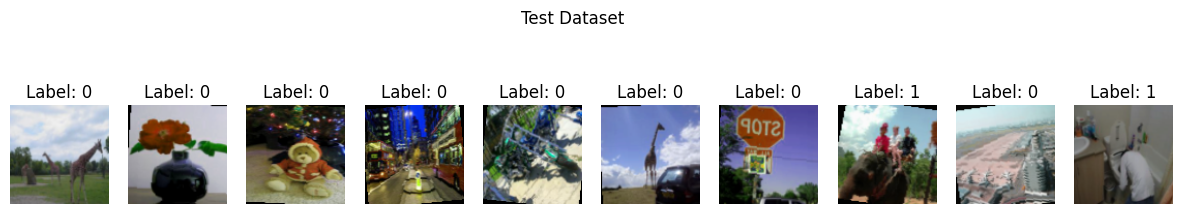

In [ ]:
# to have more human-friendly results of images we unnomalized each dataset
def unnormalize(img_tensor, mean, std):
    img_np = img_tensor.numpy().transpose((1, 2, 0)).astype(np.float32)
    img_np = img_np * np.array(std) + np.array(mean)
    img_np = np.clip(img_np, 0, 1)
    return img_np

def plot_random_images(dataset, title, num_images=10, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    fig.suptitle(title)

    for ax in axes:
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        img_np = unnormalize(img, mean, std)

        ax.imshow(img_np)
        ax.set_title(f"Label: {label}")
        ax.axis("off")

    plt.show()

plot_random_images(train_dataset, "Train Dataset")
plot_random_images(val_dataset, "Validation Dataset")
plot_random_images(test_dataset, "Test Dataset")

# Defining helper functions

In [ ]:
# A function to train and evaluate a model by printing the results of loss & accuracy
def train_and_evaluate_model(model, num_epochs, batch_size, learning_rate, train_dataset, val_dataset, test_dataset, device):

    def train(model, dataloader, criterion, optimizer, device, grad_clip=1.0):
        model.to(device).train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(dataloader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(dataloader)
        accuracy = 100 * correct / total
        return epoch_loss, accuracy

    def validate(model, dataloader, criterion, device):
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(dataloader, desc="Validation"):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(dataloader)
        accuracy = 100 * correct / total
        return epoch_loss, accuracy

    def test(model, dataloader, device):
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(dataloader, desc="Testing"):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        accuracy = 100 * correct / total
        return accuracy

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    best_val_loss = float('inf')
    patience = 10
    counter = 0
    train_acc_list = []
    val_acc_list = []


    # Training and validation loop
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model.half(), train_loader, criterion,optimizer, device)

        val_loss, val_acc = validate(model, val_loader, criterion, device)

        scheduler.step(val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
        val_acc_list.append((epoch+1,val_acc))
        train_acc_list.append((epoch+1,train_acc))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            model_name = type(model).__name__
            torch.save(model.state_dict(), f'{model_name}.pth')
            counter = 0
        else:
            counter += 1

            if counter >= patience:
                print("Early stopping triggered. Stopping training.")
                break

    model.load_state_dict(torch.load(f'{model_name}.pth'))

    test_acc = test(model, test_loader, device)
    print(f"Test Accuracy: {test_acc:.2f}%")

    return train_acc_list, val_acc_list

In [ ]:
def compute_naswot(
    net: nn.Module,
    inputs: torch.Tensor,
    device: torch.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    ) -> float:

    with torch.no_grad():
        cs = list()

        def naswot_hook(module: nn.Module, module_input: torch.Tensor, module_output: torch.Tensor) -> None:
            code = (module_output > 0).flatten(start_dim=1)
            cs.append(code)

        hooks = list()
        for m in net.modules():
            if isinstance(m, nn.ReLU):
                hooks.append(m.register_forward_hook(naswot_hook))

        net.to(device)
        inputs = inputs.to(device)
        _ = net(inputs)

        for h in hooks:
            h.remove()

        full_code = torch.cat(cs, dim=1)

        del cs, _
        full_code_float = full_code.float()
        k = full_code_float @ full_code_float.t()
        del full_code_float
        not_full_code_float = torch.logical_not(full_code).float()
        k += not_full_code_float @ not_full_code_float.t()
        naswot_score = torch.slogdet(k).logabsdet.item()
        if naswot_score == float('-inf'):
            naswot_score = 1e-6

        return naswot_score


# Generate models based on a predefined search space.
# identify the best ones based on specified metrics.

In [ ]:
# Define a custom deep neural network class that inherits from torch.nn.Module
class CustomDNN(nn.Module):
    def __init__(self, hyperparams):
        super(CustomDNN, self).__init__()

        self.blocks = nn.Sequential()
        for i in range(4, 7):
            in_channels = hyperparams[f"number_of_filters{i - 1}"] if i > 4 else 3
            # Get the other hyperparameters for the current block
            out_channels = hyperparams[f"number_of_filters{i}"]
            kernel_size = hyperparams[f"kernel_size{i}"]
            padding = hyperparams[f"padding{i}"]
            dropout_rate = hyperparams[f"dropout_rate{i}"]
            max_pooling_kernel_size = hyperparams[f"max_pooling_kernel_size{i}"]
            max_pooling_stride = hyperparams[f"max_pooling_stride{i}"]

            # Add the current block to the container using the specified hyperparameters
            self.blocks.add_module(f"block{i}", nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.MaxPool2d(max_pooling_kernel_size, stride=max_pooling_stride)
            ))

        self.fc = nn.Sequential()
        in_features = hyperparams["final_conv_output_size"]  # You need to calculate this value
        for i in range(hyperparams["number_of_fc_layers"]):
            out_features = hyperparams["number_of_neurons_per_fc_layer"]
            self.fc.add_module(f"fc{i}", nn.Linear(in_features, out_features))
            self.fc.add_module(f"relu{i}", nn.ReLU(inplace=True))
            in_features = out_features

        self.fc.add_module("dropout_fc", nn.Dropout(hyperparams["dropout_rate_fc"]))
        self.fc.add_module("output", nn.Linear(in_features, 2))
        self.fc.add_module("softmax", nn.Softmax(dim=1))

    def forward(self, x):
        x = self.blocks(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
# Checking if the hyperparameters are what we expected from search space
def check_hyperparameters(params):
    violated_conditions = []

    prev_filters = params["number_of_filters4"]
    for i in range(5, 7):
        curr_filters = params[f"number_of_filters{i}"]
        if curr_filters < prev_filters:
            violated_conditions.append(f"Condition 1 (Layer {i})")
        prev_filters = curr_filters

    for i in range(4, 7):
        kernel_size = params[f"kernel_size{i}"]
        if kernel_size not in (3, 5):
            violated_conditions.append(f"Condition 2 (Layer {i})")

    for i in range(4, 7):
        padding = params[f"padding{i}"]
        if padding not in (1, 2):
            violated_conditions.append(f"Condition 3 (Layer {i})")

    dropout_rates = [0.1, 0.2, 0.3]
    for i in range(4, 7):
        dropout_rate = params[f"dropout_rate{i}"]
        if dropout_rate not in dropout_rates:
            violated_conditions.append(f"Condition 4 (Layer {i})")

    for i in range(4, 7):
        max_pooling_kernel_size = params[f"max_pooling_kernel_size{i}"]
        max_pooling_stride = params[f"max_pooling_stride{i}"]
        if max_pooling_kernel_size not in (2, 3) or max_pooling_stride != 2:
            violated_conditions.append(f"Condition 5 (Layer {i})")

    filters = [64, 128, 256]
    if params["number_of_filters10"] not in filters:
        violated_conditions.append("Condition 6")

    fc_layers = [2, 3]
    if params["number_of_fc_layers"] not in fc_layers:
        violated_conditions.append("Condition 7")

    fc_neurons = [32, 64, 96, 128]
    if params["number_of_neurons_per_fc_layer"] not in fc_neurons:
        violated_conditions.append("Condition 8")

    fc_dropout = [0.2, 0.3, 0.4]
    if params["dropout_rate_fc"] not in fc_dropout:
        violated_conditions.append("Condition 9")

    if violated_conditions:
        print("Violated conditions:", violated_conditions)
        return False

    return True

In [ ]:
search_space = {
    "number_of_filters4": (16, 64),
    "number_of_filters5": (32, 128),
    "number_of_filters6": (64, 256),
    "kernel_size4": [3, 5],
    "kernel_size5": [3, 5],
    "kernel_size6": [3, 5],
    "padding4": [1, 2],
    "padding5": [1, 2],
    "padding6": [1, 2],
    "dropout_rate4": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    "dropout_rate5": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    "dropout_rate6": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    "max_pooling_kernel_size4": [2, 3],
    "max_pooling_kernel_size5": [2, 3],
    "max_pooling_kernel_size6": [2, 3],
    "max_pooling_stride4": [1, 2],
    "max_pooling_stride5": [1, 2],
    "max_pooling_stride6": [1, 2],
    "dropout_rate_fc": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    "number_of_filters10": [32, 64, 128, 256, 512],
    "number_of_fc_layers": [1, 2, 3],
    "number_of_neurons_per_fc_layer": [16, 32, 64, 128],
}

In [ ]:
def generate_hyperparameters(search_space):
    hyperparameters = {
        "number_of_filters4": random.randint(*search_space["number_of_filters4"]),
        "number_of_filters5": random.randint(*search_space["number_of_filters5"]),
        "number_of_filters6": random.randint(*search_space["number_of_filters6"]),
        "kernel_size4": random.choice(search_space["kernel_size4"]),
        "kernel_size5": random.choice(search_space["kernel_size5"]),
        "kernel_size6": random.choice(search_space["kernel_size6"]),
        "padding4": random.choice(search_space["padding4"]),
        "padding5": random.choice(search_space["padding5"]),
        "padding6": random.choice(search_space["padding6"]),
        "dropout_rate4": random.choice(search_space["dropout_rate4"]),
        "dropout_rate5": random.choice(search_space["dropout_rate5"]),
        "dropout_rate6": random.choice(search_space["dropout_rate6"]),
        "max_pooling_kernel_size4": random.choice(search_space["max_pooling_kernel_size4"]),
        "max_pooling_kernel_size5": random.choice(search_space["max_pooling_kernel_size5"]),
        "max_pooling_kernel_size6": random.choice(search_space["max_pooling_kernel_size6"]),
        "max_pooling_stride4": random.choice(search_space["max_pooling_stride4"]),
        "max_pooling_stride5": random.choice(search_space["max_pooling_stride5"]),
        "max_pooling_stride6": random.choice(search_space["max_pooling_stride6"]),
        "dropout_rate_fc": random.choice(search_space["dropout_rate_fc"]),
        "number_of_filters10": random.choice(search_space["number_of_filters10"]),
        "number_of_fc_layers": random.choice(search_space["number_of_fc_layers"]),
        "number_of_neurons_per_fc_layer": random.choice(search_space["number_of_neurons_per_fc_layer"]),
    }
    return hyperparameters

In [ ]:
def calculate_final_conv_output_size(input_size, hyperparams):
    output_size = input_size
    for i in range(4, 7):
        kernel_size = hyperparams[f"kernel_size{i}"]
        padding = hyperparams[f"padding{i}"]
        max_pooling_kernel_size = hyperparams[f"max_pooling_kernel_size{i}"]
        max_pooling_stride = hyperparams[f"max_pooling_stride{i}"]

        # Calculate the output size after the convolutional layer
        output_size = (output_size + 2 * padding - kernel_size) // 1 + 1

        # Calculate the output size after the max pooling layer
        output_size = (output_size - max_pooling_kernel_size) // max_pooling_stride + 1

    return output_size**2 * hyperparams["number_of_filters6"]

## First metric for finding best model : Naswot_score

In [ ]:
MAX_MODELS = 500
MAX_RETRIES = 20000
input_image_size = 96
models = []

# Continue generating models until the desired number of models is reached
while len(models) < MAX_MODELS:
    for i in range(MAX_RETRIES):
        hyperparameters = generate_hyperparameters(search_space)
        if check_hyperparameters(hyperparameters):
            final_conv_output_size = calculate_final_conv_output_size(input_image_size, hyperparameters)
            hyperparameters["final_conv_output_size"] = final_conv_output_size
            print(f'Generated model {len(models)} at attempt {i}')
            model = CustomDNN(hyperparameters)
            models.append(model)
            break

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
naswot_scores = []

for i, model in enumerate(models):
    input, _ = next(iter(train_loader))
    input = input.to(device)
    naswot_score = compute_naswot(model.half().to(device), input, device)
    naswot_scores.append(naswot_score)
    print(f"NASWOT score for model {i}: {naswot_score}")

ranked_models = sorted(zip(naswot_scores, models), key=lambda x: x[0])

print("Ranked models:")
for i, (score, model) in enumerate(ranked_models):
    print(f"{i + 1}. Model {models.index(model)}, NASWOT score: {score}")

# Choose the model with the highest NASWOT score
best_score, best_model_naswot = ranked_models[-1]
print(f"Best model: Model {models.index(best_model_naswot)}, NASWOT score: {best_score}")

Streaming output truncated to the last 5000 lines.
Violated conditions: ['Condition 1 (Layer 5)', 'Condition 4 (Layer 4)', 'Condition 5 (Layer 4)', 'Condition 6', 'Condition 8', 'Condition 9']
Violated conditions: ['Condition 4 (Layer 6)', 'Condition 8']
Violated conditions: ['Condition 4 (Layer 5)', 'Condition 4 (Layer 6)', 'Condition 5 (Layer 4)', 'Condition 5 (Layer 5)', 'Condition 5 (Layer 6)']
Violated conditions: ['Condition 4 (Layer 5)', 'Condition 5 (Layer 5)', 'Condition 6', 'Condition 7', 'Condition 9']
Violated conditions: ['Condition 1 (Layer 6)', 'Condition 4 (Layer 4)', 'Condition 7']
Violated conditions: ['Condition 4 (Layer 5)', 'Condition 4 (Layer 6)', 'Condition 5 (Layer 4)', 'Condition 7', 'Condition 8']
Violated conditions: ['Condition 4 (Layer 4)']
Violated conditions: ['Condition 4 (Layer 4)', 'Condition 5 (Layer 4)', 'Condition 6', 'Condition 7', 'Condition 8', 'Condition 9']
Violated conditions: ['Condition 1 (Layer 5)', 'Condition 4 (Layer 4)', 'Condition 4 (La

In [ ]:
summary(best_model_naswot)

Layer (type:depth-idx)                   Param #
CustomDNN                                --
├─Sequential: 1-1                        --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  1,680
│    │    └─BatchNorm2d: 3-2             120
│    │    └─ReLU: 3-3                    --
│    │    └─Dropout: 3-4                 --
│    │    └─MaxPool2d: 3-5               --
│    └─Sequential: 2-2                   --
│    │    └─Conv2d: 3-6                  68,707
│    │    └─BatchNorm2d: 3-7             254
│    │    └─ReLU: 3-8                    --
│    │    └─Dropout: 3-9                 --
│    │    └─MaxPool2d: 3-10              --
│    └─Sequential: 2-3                   --
│    │    └─Conv2d: 3-11                 682,840
│    │    └─BatchNorm2d: 3-12            430
│    │    └─ReLU: 3-13                   --
│    │    └─Dropout: 3-14                --
│    │    └─MaxPool2d: 3-15              --
├─Sequential: 1-2                        --
│    └─Linea

## Second metric for finding best model : ArchScore

In [ ]:
def calculate_output_shape(input_shape, kernel_size, padding, stride):
    output_height = (input_shape[0] - kernel_size[0] + 2 * padding[0]) // stride[0] + 1
    output_width = (input_shape[1] - kernel_size[1] + 2 * padding[1]) // stride[1] + 1
    return output_height, output_width

def extract_model_info(model, input_shape=(3, 96, 96)):
    number_of_filters = []
    kernel_sizes = []
    number_of_fc_layers = 0
    number_of_conv_layers = 0
    total_flops = 0
    total_params = 0
    width = 0
    depth = 0
    receptive_field_size = 1

    current_shape = input_shape

    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d):
            number_of_conv_layers += 1
            number_of_filters.append(layer.out_channels)
            kernel_sizes.append(layer.kernel_size)
            receptive_field_size += (layer.kernel_size[0] - 1)

            output_shape = calculate_output_shape(
                current_shape[1:],
                layer.kernel_size,
                layer.padding,
                layer.stride
            )
            # Calculate FLOPs and update the total FLOPs
            flops = (layer.kernel_size[0] * layer.kernel_size[1] *
                     layer.in_channels * layer.out_channels *
                     output_shape[0] * output_shape[1])
            total_flops += flops

            # Update total parameters for the current layer
            total_params += sum(p.numel() for p in layer.parameters())

            # Update width and depth
            width = max(width, layer.out_channels)
            depth += 1

            # Update the current_shape for the next layer
            current_shape = (layer.out_channels, *output_shape)

        elif isinstance(layer, nn.Linear):
          # Update the counter for fully connected layers and depth
            number_of_fc_layers += 1
            total_params += sum(p.numel() for p in layer.parameters())
            depth += 1
    # Return the extracted model information as a dictionary
    return {
        "Number of filters": number_of_filters,
        "Kernel sizes": kernel_sizes,
        "Number of fully connected layers": number_of_fc_layers,
        "FLOPs": total_flops,
        "Parameters": total_params,
        "Width": width,
        "Depth": depth,
        "Receptive field size": receptive_field_size,
        "Number of convolutional layers": number_of_conv_layers
    }

# Normalize a score between min_val and max_val
def normalize(score, min_val, max_val, epsilon=1e-9):
    return (score - min_val) / (max_val - min_val + epsilon)

# Calculate the weighted score of a model given its information and the weights for different metrics
def model_score(model_info, flops_weight, params_weight, fc_layers_weight,
                depth_weight, width_weight, receptive_field_weight, conv_layers_weight,
                min_flops, max_flops, min_params, max_params, min_fc_layers, max_fc_layers,
                min_depth, max_depth, min_width, max_width, min_receptive_field, max_receptive_field,
                min_conv_layers, max_conv_layers):

    # Calculate normalized scores for each metric
    flops_score = normalize(model_info["FLOPs"], min_flops, max_flops)
    params_score = normalize(model_info["Parameters"], min_params, max_params)
    fc_layers_score = normalize(model_info["Number of fully connected layers"], min_fc_layers, max_fc_layers)
    depth_score = normalize(model_info["Depth"], min_depth, max_depth)
    width_score = normalize(model_info["Width"], min_width, max_width)
    receptive_field_score = normalize(model_info["Receptive field size"], min_receptive_field, max_receptive_field)
    conv_layers_score = normalize(model_info["Number of convolutional layers"], min_conv_layers, max_conv_layers)

    # Calculate the weighted score by summing up the weighted normalized scores
    weighted_score = (
        flops_weight * flops_score +
        params_weight * params_score +
        fc_layers_weight * fc_layers_score +
        depth_weight * depth_score +
        width_weight * width_score +
        receptive_field_weight * receptive_field_score +
        conv_layers_weight * conv_layers_score
    )

    return weighted_score

def model_score_wrapper(flops_weight, params_weight, fc_layers_weight,
                        depth_weight, width_weight, receptive_field_weight, conv_layers_weight):
    return model_score(model_info, flops_weight, params_weight, fc_layers_weight,
                       depth_weight, width_weight, receptive_field_weight, conv_layers_weight,
                       min_flops, max_flops, min_params, max_params, min_fc_layers, max_fc_layers,
                       min_depth, max_depth, min_width, max_width, min_receptive_field, max_receptive_field,
                       min_conv_layers, max_conv_layers)

bounds = {
    'flops_weight': (0.01, 1),
    'params_weight': (0.01, 1),
    'fc_layers_weight': (0.01, 1),
    'depth_weight': (0.01, 1),
    'width_weight': (0.01, 1),
    'receptive_field_weight': (0.01, 1),
    'conv_layers_weight': (0.01, 1)
}

# Extract model information for each model and calculate the min and max values for each metric
min_flops = float('inf')
max_flops = 0
min_params = float('inf')
max_params = 0
min_fc_layers = float('inf')
max_fc_layers = 0
min_depth = float('inf')
max_depth = 0
min_width = float('inf')
max_width = 0
min_receptive_field = float('inf')
max_receptive_field = 0
min_conv_layers = float('inf')
max_conv_layers = 0

model_infos = []

# Replace 'models' with your list of models
for model in models:
    model_info = extract_model_info(model)
    model_infos.append(model_info)

    min_flops = min(min_flops, model_info["FLOPs"])
    max_flops = max(max_flops, model_info["FLOPs"])
    min_params = min(min_params, model_info["Parameters"])
    max_params = max(max_params, model_info["Parameters"])
    min_fc_layers = min(min_fc_layers, model_info["Number of fully connected layers"])
    max_fc_layers = max(max_fc_layers, model_info["Number of fully connected layers"])
    min_depth = min(min_depth, model_info["Depth"])
    max_depth = max(max_depth, model_info["Depth"])
    min_width = min(min_width, model_info["Width"])
    max_width = max(max_width, model_info["Width"])
    min_receptive_field = min(min_receptive_field, model_info["Receptive field size"])
    max_receptive_field = max(max_receptive_field, model_info["Receptive field size"])
    min_conv_layers = min(min_conv_layers, model_info["Number of convolutional layers"])
    max_conv_layers = max(max_conv_layers, model_info["Number of convolutional layers"])

# Bayesian optimization
optimizer = BayesianOptimization(
    f=model_score_wrapper,
    pbounds=bounds,
    random_state=42,
    allow_duplicate_points=True

)

optimizer.maximize(
    init_points=5,
    n_iter=10
)

best_weights = optimizer.max['params']

# Update the best_weights dictionary with min and max values
best_weights.update({
    'min_flops': min_flops, 'max_flops': max_flops,
    'min_params': min_params, 'max_params': max_params,
    'min_fc_layers': min_fc_layers, 'max_fc_layers': max_fc_layers,
    'min_depth': min_depth, 'max_depth': max_depth,
    'min_width': min_width, 'max_width': max_width,
    'min_receptive_field': min_receptive_field, 'max_receptive_field': max_receptive_field,
    'min_conv_layers': min_conv_layers, 'max_conv_layers': max_conv_layers
})

# Evaluate and rank models
model_scores = []
for model_info in model_infos:
    score = model_score(model_info, **best_weights)
    model_scores.append(score)

sorted_model_indices = np.argsort(model_scores)[::-1]

print("Ranked Models:")

for i, index in enumerate(sorted_model_indices):
    print(f"Rank {i + 1}: Model {index}, Score: {model_scores[index]}")

idx_best_model_arch = sorted_model_indices[-1]
best_model_arch = models[idx_best_model_arch]
print(f"Best model: Model {models.index(best_model_arch)}")

|   iter    |  target   | conv_l... | depth_... | fc_lay... | flops_... | params... | recept... | width_... |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.4657    | 0.3808    | 0.9512    | 0.7347    | 0.6027    | 0.1645    | 0.1644    | 0.0675    |
| 2         | 0.9448    | 0.8675    | 0.6051    | 0.711     | 0.03038   | 0.9702    | 0.8341    | 0.2202    |
| 3         | 0.7473    | 0.19      | 0.1916    | 0.3112    | 0.5295    | 0.4376    | 0.2983    | 0.6157    |
| 4         | 0.7456    | 0.1481    | 0.2992    | 0.3727    | 0.4615    | 0.7873    | 0.2077    | 0.5191    |
| 5         | 0.9835    | 0.5965    | 0.05599   | 0.6115    | 0.1788    | 0.0744    | 0.9494    | 0.966     |
| 6         | 1.226     | 1.0       | 0.01      | 0.7493    | 0.01      | 0.9268    | 1.0       | 1.0       |
| 7         | 1.25      | 1.0       | 0.01      | 0.01      | 0.01      | 1.0       | 1.0       | 1.0       |
| 8       

In [ ]:
summary(best_model_arch)

Layer (type:depth-idx)                   Param #
CustomDNN                                --
├─Sequential: 1-1                        --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  1,064
│    │    └─BatchNorm2d: 3-2             76
│    │    └─ReLU: 3-3                    --
│    │    └─Dropout: 3-4                 --
│    │    └─MaxPool2d: 3-5               --
│    └─Sequential: 2-2                   --
│    │    └─Conv2d: 3-6                  14,406
│    │    └─BatchNorm2d: 3-7             84
│    │    └─ReLU: 3-8                    --
│    │    └─Dropout: 3-9                 --
│    │    └─MaxPool2d: 3-10              --
│    └─Sequential: 2-3                   --
│    │    └─Conv2d: 3-11                 28,046
│    │    └─BatchNorm2d: 3-12            148
│    │    └─ReLU: 3-13                   --
│    │    └─Dropout: 3-14                --
│    │    └─MaxPool2d: 3-15              --
├─Sequential: 1-2                        --
│    └─Linear: 

# Training the best_models base on each metric

In [ ]:
train_acc_naswot, val_acc_naswot = train_and_evaluate_model(model=best_model_naswot, num_epochs=40, batch_size=32, learning_rate=0.01, train_dataset=train_dataset, val_dataset=val_dataset, test_dataset=test_dataset, device=device)

Validation: 100%|██████████| 554/554 [00:04<00:00, 117.91it/s]


Epoch 1/40:
Train Loss: 0.6251, Train Accuracy: 65.59%
Validation Loss: 0.6088, Validation Accuracy: 67.84%


Validation: 100%|██████████| 554/554 [00:04<00:00, 117.20it/s]


Epoch 2/40:
Train Loss: 0.5922, Train Accuracy: 69.72%
Validation Loss: 0.5978, Validation Accuracy: 68.84%


Validation: 100%|██████████| 554/554 [00:04<00:00, 116.37it/s]


Epoch 3/40:
Train Loss: 0.5771, Train Accuracy: 71.45%
Validation Loss: 0.6071, Validation Accuracy: 67.91%


Validation: 100%|██████████| 554/554 [00:04<00:00, 116.41it/s]


Epoch 4/40:
Train Loss: 0.5661, Train Accuracy: 72.72%
Validation Loss: 0.5850, Validation Accuracy: 70.25%


Validation: 100%|██████████| 554/554 [00:04<00:00, 116.35it/s]


Epoch 5/40:
Train Loss: 0.5558, Train Accuracy: 73.99%
Validation Loss: 0.5735, Validation Accuracy: 71.88%


Validation: 100%|██████████| 554/554 [00:04<00:00, 114.41it/s]


Epoch 6/40:
Train Loss: 0.5471, Train Accuracy: 74.97%
Validation Loss: 0.5878, Validation Accuracy: 70.40%


Validation: 100%|██████████| 554/554 [00:04<00:00, 115.57it/s]


Epoch 7/40:
Train Loss: 0.5395, Train Accuracy: 75.88%
Validation Loss: 0.5466, Validation Accuracy: 74.93%


Validation: 100%|██████████| 554/554 [00:04<00:00, 114.89it/s]


Epoch 8/40:
Train Loss: 0.5327, Train Accuracy: 76.61%
Validation Loss: 0.5692, Validation Accuracy: 72.56%


Validation: 100%|██████████| 554/554 [00:04<00:00, 118.76it/s]


Epoch 9/40:
Train Loss: 0.5261, Train Accuracy: 77.44%
Validation Loss: 0.5479, Validation Accuracy: 74.65%


Validation: 100%|██████████| 554/554 [00:04<00:00, 119.13it/s]


Epoch 10/40:
Train Loss: 0.5203, Train Accuracy: 78.03%
Validation Loss: 0.5443, Validation Accuracy: 75.22%


Validation: 100%|██████████| 554/554 [00:04<00:00, 119.55it/s]


Epoch 11/40:
Train Loss: 0.5147, Train Accuracy: 78.64%
Validation Loss: 0.5440, Validation Accuracy: 75.10%


Validation: 100%|██████████| 554/554 [00:04<00:00, 118.55it/s]


Epoch 12/40:
Train Loss: 0.5087, Train Accuracy: 79.41%
Validation Loss: 0.5824, Validation Accuracy: 71.23%


Validation: 100%|██████████| 554/554 [00:04<00:00, 118.60it/s]


Epoch 13/40:
Train Loss: 0.5040, Train Accuracy: 79.90%
Validation Loss: 0.5734, Validation Accuracy: 72.67%


Validation: 100%|██████████| 554/554 [00:04<00:00, 119.20it/s]


Epoch 14/40:
Train Loss: 0.4994, Train Accuracy: 80.40%
Validation Loss: 0.5654, Validation Accuracy: 72.76%


Validation: 100%|██████████| 554/554 [00:04<00:00, 118.78it/s]


Epoch 15/40:
Train Loss: 0.4923, Train Accuracy: 81.22%
Validation Loss: 0.5490, Validation Accuracy: 74.96%


Validation: 100%|██████████| 554/554 [00:04<00:00, 118.85it/s]


Epoch 16/40:
Train Loss: 0.4880, Train Accuracy: 81.65%
Validation Loss: 0.5957, Validation Accuracy: 70.44%


Validation: 100%|██████████| 554/554 [00:04<00:00, 116.99it/s]


Epoch 17/40:
Train Loss: 0.4821, Train Accuracy: 82.40%
Validation Loss: 0.6204, Validation Accuracy: 67.52%


Validation: 100%|██████████| 554/554 [00:04<00:00, 116.09it/s]


Epoch 18/40:
Train Loss: 0.4776, Train Accuracy: 82.82%
Validation Loss: 0.5334, Validation Accuracy: 76.52%


Validation: 100%|██████████| 554/554 [00:04<00:00, 117.02it/s]


Epoch 19/40:
Train Loss: 0.4742, Train Accuracy: 83.17%
Validation Loss: 0.5649, Validation Accuracy: 73.50%


Validation: 100%|██████████| 554/554 [00:04<00:00, 115.60it/s]


Epoch 20/40:
Train Loss: 0.4699, Train Accuracy: 83.71%
Validation Loss: 0.5575, Validation Accuracy: 74.20%


Validation: 100%|██████████| 554/554 [00:04<00:00, 116.75it/s]


Epoch 21/40:
Train Loss: 0.4652, Train Accuracy: 84.21%
Validation Loss: 0.5490, Validation Accuracy: 75.25%


Validation: 100%|██████████| 554/554 [00:04<00:00, 115.89it/s]


Epoch 22/40:
Train Loss: 0.4602, Train Accuracy: 84.76%
Validation Loss: 0.5868, Validation Accuracy: 71.36%


Validation: 100%|██████████| 554/554 [00:04<00:00, 116.88it/s]


Epoch 23/40:
Train Loss: 0.4562, Train Accuracy: 85.15%
Validation Loss: 0.5439, Validation Accuracy: 75.70%


Validation: 100%|██████████| 554/554 [00:04<00:00, 116.58it/s]


Epoch 24/40:
Train Loss: 0.4536, Train Accuracy: 85.49%
Validation Loss: 0.5489, Validation Accuracy: 75.13%


Validation: 100%|██████████| 554/554 [00:04<00:00, 117.50it/s]


Epoch 25/40:
Train Loss: 0.4490, Train Accuracy: 85.97%
Validation Loss: 0.5383, Validation Accuracy: 76.42%


Validation: 100%|██████████| 554/554 [00:04<00:00, 118.22it/s]


Epoch 26/40:
Train Loss: 0.4469, Train Accuracy: 86.23%
Validation Loss: 0.5406, Validation Accuracy: 76.07%


Validation: 100%|██████████| 554/554 [00:04<00:00, 119.01it/s]


Epoch 27/40:
Train Loss: 0.4416, Train Accuracy: 86.73%
Validation Loss: 0.5623, Validation Accuracy: 74.01%


Validation: 100%|██████████| 554/554 [00:04<00:00, 118.92it/s]


Epoch 28/40:
Train Loss: 0.4396, Train Accuracy: 86.95%
Validation Loss: 0.5613, Validation Accuracy: 74.29%
Early stopping triggered. Stopping training.


Testing: 100%|██████████| 554/554 [00:04<00:00, 116.78it/s]

Test Accuracy: 75.60%


In [ ]:
train_acc_arch, val_acc_arch = train_and_evaluate_model(model=best_model_arch, num_epochs=40, batch_size=32, learning_rate=0.01, train_dataset=train_dataset, val_dataset=val_dataset, test_dataset=test_dataset, device=device)

Validation: 100%|██████████| 554/554 [00:03<00:00, 182.56it/s]


Epoch 1/40:
Train Loss: 0.6437, Train Accuracy: 63.29%
Validation Loss: 0.6303, Validation Accuracy: 63.90%


Validation: 100%|██████████| 554/554 [00:03<00:00, 175.34it/s]


Epoch 2/40:
Train Loss: 0.6151, Train Accuracy: 66.89%
Validation Loss: 0.6422, Validation Accuracy: 62.45%


Validation: 100%|██████████| 554/554 [00:03<00:00, 180.67it/s]


Epoch 3/40:
Train Loss: 0.6025, Train Accuracy: 68.67%
Validation Loss: 0.6025, Validation Accuracy: 67.46%


Validation: 100%|██████████| 554/554 [00:03<00:00, 181.16it/s]


Epoch 4/40:
Train Loss: 0.5933, Train Accuracy: 69.62%
Validation Loss: 0.5919, Validation Accuracy: 69.85%


Validation: 100%|██████████| 554/554 [00:03<00:00, 182.91it/s]


Epoch 5/40:
Train Loss: 0.5853, Train Accuracy: 70.65%
Validation Loss: 0.6005, Validation Accuracy: 69.41%


Validation: 100%|██████████| 554/554 [00:03<00:00, 179.55it/s]


Epoch 6/40:
Train Loss: 0.5772, Train Accuracy: 71.54%
Validation Loss: 0.5774, Validation Accuracy: 71.29%


Validation: 100%|██████████| 554/554 [00:03<00:00, 182.39it/s]


Epoch 7/40:
Train Loss: 0.5711, Train Accuracy: 72.38%
Validation Loss: 0.5718, Validation Accuracy: 72.22%


Validation: 100%|██████████| 554/554 [00:03<00:00, 180.75it/s]


Epoch 8/40:
Train Loss: 0.5645, Train Accuracy: 73.08%
Validation Loss: 0.5779, Validation Accuracy: 71.70%


Validation: 100%|██████████| 554/554 [00:03<00:00, 176.19it/s]


Epoch 9/40:
Train Loss: 0.5587, Train Accuracy: 73.72%
Validation Loss: 0.5647, Validation Accuracy: 72.99%


Validation: 100%|██████████| 554/554 [00:03<00:00, 181.89it/s]


Epoch 10/40:
Train Loss: 0.5513, Train Accuracy: 74.71%
Validation Loss: 0.5890, Validation Accuracy: 70.51%


Validation: 100%|██████████| 554/554 [00:03<00:00, 170.86it/s]


Epoch 11/40:
Train Loss: 0.5482, Train Accuracy: 74.96%
Validation Loss: 0.5746, Validation Accuracy: 71.63%


Validation: 100%|██████████| 554/554 [00:03<00:00, 180.71it/s]


Epoch 12/40:
Train Loss: 0.5424, Train Accuracy: 75.72%
Validation Loss: 0.5699, Validation Accuracy: 72.31%


Validation: 100%|██████████| 554/554 [00:03<00:00, 174.87it/s]


Epoch 13/40:
Train Loss: 0.5381, Train Accuracy: 76.14%
Validation Loss: 0.5517, Validation Accuracy: 74.51%


Validation: 100%|██████████| 554/554 [00:03<00:00, 180.65it/s]


Epoch 14/40:
Train Loss: 0.5324, Train Accuracy: 76.72%
Validation Loss: 0.5544, Validation Accuracy: 74.13%


Validation: 100%|██████████| 554/554 [00:03<00:00, 177.29it/s]


Epoch 15/40:
Train Loss: 0.5271, Train Accuracy: 77.43%
Validation Loss: 0.5637, Validation Accuracy: 73.16%


Validation: 100%|██████████| 554/554 [00:03<00:00, 183.18it/s]


Epoch 16/40:
Train Loss: 0.5221, Train Accuracy: 77.93%
Validation Loss: 0.5550, Validation Accuracy: 74.18%


Validation: 100%|██████████| 554/554 [00:03<00:00, 178.55it/s]


Epoch 17/40:
Train Loss: 0.5178, Train Accuracy: 78.55%
Validation Loss: 0.5489, Validation Accuracy: 74.73%


Validation: 100%|██████████| 554/554 [00:03<00:00, 182.47it/s]


Epoch 18/40:
Train Loss: 0.5142, Train Accuracy: 78.86%
Validation Loss: 0.5792, Validation Accuracy: 71.80%


Validation: 100%|██████████| 554/554 [00:03<00:00, 184.60it/s]


Epoch 19/40:
Train Loss: 0.5110, Train Accuracy: 79.29%
Validation Loss: 0.5480, Validation Accuracy: 75.09%


Validation: 100%|██████████| 554/554 [00:03<00:00, 175.33it/s]


Epoch 20/40:
Train Loss: 0.5067, Train Accuracy: 79.74%
Validation Loss: 0.5982, Validation Accuracy: 69.99%


Validation: 100%|██████████| 554/554 [00:03<00:00, 183.76it/s]


Epoch 21/40:
Train Loss: 0.5037, Train Accuracy: 80.10%
Validation Loss: 0.5548, Validation Accuracy: 74.34%


Validation: 100%|██████████| 554/554 [00:03<00:00, 176.12it/s]


Epoch 22/40:
Train Loss: 0.5016, Train Accuracy: 80.32%
Validation Loss: 0.5656, Validation Accuracy: 73.05%


Validation: 100%|██████████| 554/554 [00:03<00:00, 181.94it/s]


Epoch 23/40:
Train Loss: 0.4988, Train Accuracy: 80.66%
Validation Loss: 0.5569, Validation Accuracy: 74.22%


Validation: 100%|██████████| 554/554 [00:03<00:00, 173.07it/s]


Epoch 24/40:
Train Loss: 0.4959, Train Accuracy: 81.00%
Validation Loss: 0.5670, Validation Accuracy: 73.18%


Validation: 100%|██████████| 554/554 [00:03<00:00, 181.79it/s]


Epoch 25/40:
Train Loss: 0.4942, Train Accuracy: 81.14%
Validation Loss: 0.5513, Validation Accuracy: 74.82%


Validation: 100%|██████████| 554/554 [00:03<00:00, 174.87it/s]


Epoch 26/40:
Train Loss: 0.4917, Train Accuracy: 81.40%
Validation Loss: 0.5556, Validation Accuracy: 74.22%


Validation: 100%|██████████| 554/554 [00:03<00:00, 183.52it/s]


Epoch 27/40:
Train Loss: 0.4885, Train Accuracy: 81.83%
Validation Loss: 0.5569, Validation Accuracy: 73.96%


Validation: 100%|██████████| 554/554 [00:03<00:00, 178.27it/s]


Epoch 28/40:
Train Loss: 0.4867, Train Accuracy: 81.97%
Validation Loss: 0.5602, Validation Accuracy: 73.69%


Validation: 100%|██████████| 554/554 [00:03<00:00, 182.05it/s]


Epoch 29/40:
Train Loss: 0.4855, Train Accuracy: 82.13%
Validation Loss: 0.5612, Validation Accuracy: 73.81%
Early stopping triggered. Stopping training.


Testing: 100%|██████████| 554/554 [00:03<00:00, 179.40it/s]

Test Accuracy: 73.82%


In [ ]:
torch.save(best_model_naswot.state_dict(), 'best_model_naswot.pth')
torch.save(best_model_arch.state_dict(), 'best_model_arch.pth')

# Visualizing some Data

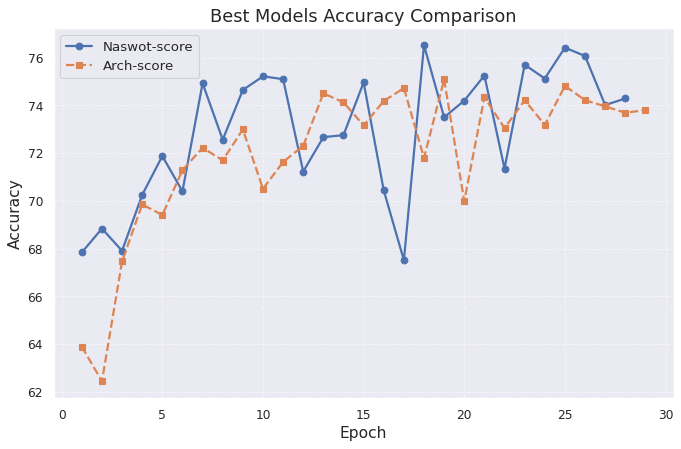

In [ ]:
sns.set()
plt.figure(figsize=(10, 6), dpi=80)
epochs1, acc1 = zip(*val_acc_naswot)
epochs2, acc2 = zip(*val_acc_arch)

plt.plot(epochs1, acc1, label='Naswot-score', linewidth=2, linestyle='-', marker='o', markersize=6)
plt.plot(epochs2, acc2, label='Arch-score', linewidth=2, linestyle='--', marker='s', markersize=6)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Best Models Accuracy Comparison', fontsize=16)
plt.show()

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

!pip install opencv-python-headless torchvision

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image


def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
model = best_model_naswot
model.eval().to(device)

transforms = Compose([
    Resize((96, 96)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

photo_filename = take_photo()

image = Image.open(photo_filename)
input_tensor = transforms(image).unsqueeze(0).to(device).half()

with torch.no_grad():
    output = model(input_tensor)
    _, predicted_class = torch.max(output, 1)

print(f"Predicted class: {predicted_class.item()}")

<IPython.core.display.Javascript object>

Predicted class: 1


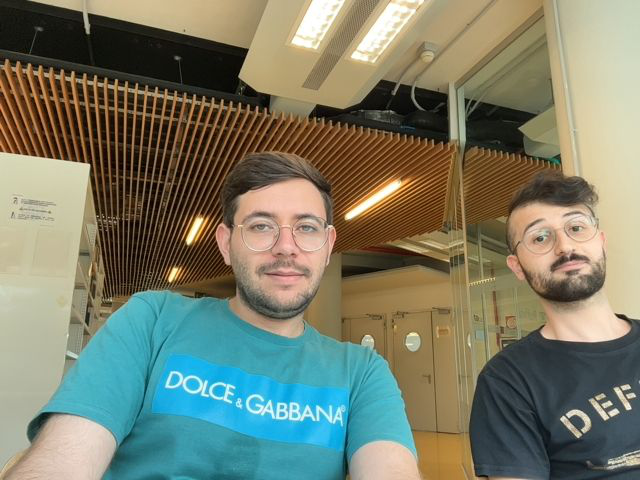

In [ ]:
image